# Notebook
In this notebook, we present the main results from the experiments.

In [101]:
max_n_time_steps = 100000
rolling_window = int(max_n_time_steps/20)

experiment_dir_set = ['0peucrl', '1peucrl', '2peucrl', '0noshielding', '1noshielding', '2noshielding', '0noshieldingnopruning', '1noshieldingnopruning', '2noshieldingnopruning']
agent_id_set = ['peucrl', 'peucrl', 'peucrl', 'noshielding', 'noshielding','noshielding', 'noshieldingnopruning', 'noshieldingnopruning', 'noshieldingnopruning']

## Initialisations

In [102]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import seaborn.objects as so
sns.set_theme()
%matplotlib inline

In [103]:
data = [pd.DataFrame for _ in range(len(experiment_dir_set))]
for i, experiment_dir in enumerate(experiment_dir_set):
    data[i] = pd.read_csv(
        'results/' + experiment_dir + '/data.csv',
        index_col='time_step',
        nrows=max_n_time_steps,
    )


## Plots

### Side Effects

In [104]:
def extract_series(name, i, data, set):
    tmp = data[i][name]
    tmp = tmp.to_frame()
    tmp = tmp.rename(columns={name: set[i]})
    return tmp

side_effects = extract_series('side_effects_incidence', 0, data, agent_id_set)
for i in range(1, len(experiment_dir_set)):
    tmp = extract_series('side_effects_incidence', i, data, agent_id_set)
    side_effects = pd.concat([side_effects, tmp], axis=1)

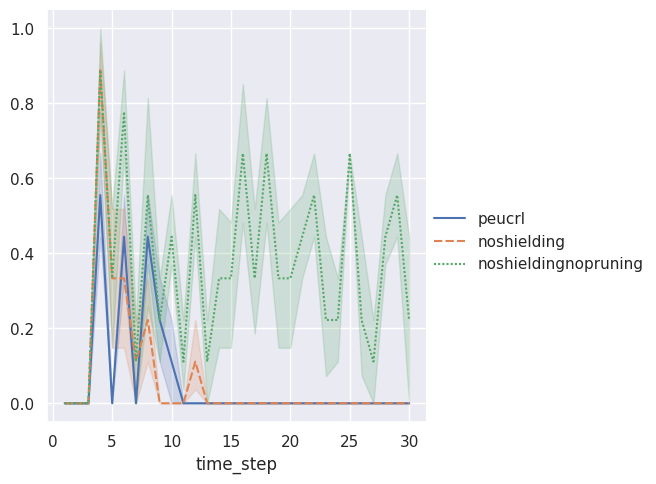

In [105]:
sns.relplot(
    side_effects[:30],
    kind='line',
)

In [106]:
sns.relplot(
    side_effects[30:].rolling(rolling_window).max(),
    kind='line',
)

### Reward

In [ ]:
def extract_series(name, i, data, set):
    tmp = data[i][name]
    tmp = tmp.to_frame()
    tmp = tmp.rename(columns={name: set[i]})
    return tmp

reward = extract_series('reward', 0, data, agent_id_set)
for i in range(1, len(experiment_dir_set)):
    tmp = extract_series('reward', i, data, agent_id_set)
    reward = pd.concat([reward, tmp], axis=1)

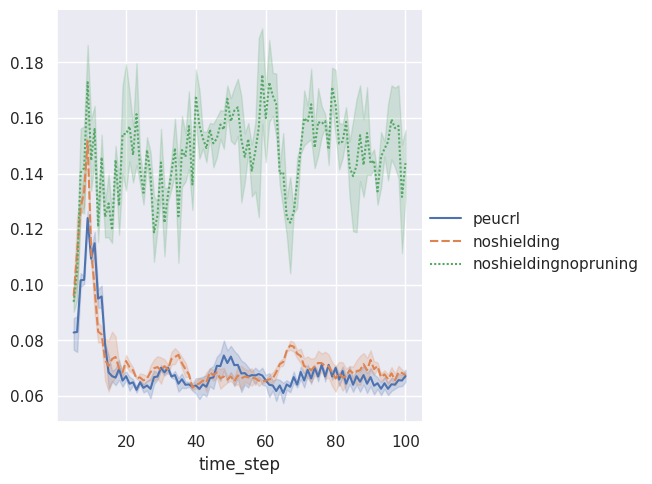

In [ ]:
sns.relplot(
    data=reward.rolling(rolling_window).mean(),
    kind='line',
)